# 118B Final Project: Target Risk-Genes of ASD
Yufei Deng, Mengyu Zhang

## Dataset:
- Source: Gene Expression Omnibus (GEO) 

    - Alter MD, Kharkar R, Ramsey KE, Craig DW et al. Autism and increased paternal age related changes in global levels of gene expression regulation. PLoS One 2011 Feb 17;6(2):e16715. PMID: 21379579
- Link to data: https://ftp.ncbi.nlm.nih.gov/geo/series/GSE25nnn/GSE25507/matrix/


## Objectives
Using Feature Selection techniques and classification algorithms to pinpoint a set of risk genes of ASD in children

## Data Analysis

In [1]:
# !pip install umap-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ='retina'

import seaborn as sns
import umap

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import linear_model as lm

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [3]:
gene = pd.read_csv('Data/ASD gene expression.csv', header=None).transpose()

/Users/yufeideng/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
# reset var headers
gene.columns = gene.iloc[0,:]
gene = gene.iloc[1:,:-1]
gene = gene.drop(columns=['age', 'paternal age','maternal age'])

# clean 'group' column
gene['group'] = gene['group'].apply(lambda x: x[x.index(':')+2 : ])

,group,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,90610_at,91580_at,91617_at,91682_at,91684_g_at,91703_at,91816_f_at,91826_at,91920_at,91952_at
1,group: control,179.823156,118.4835531,1185.853438,133.9321958,7.221822691,992.3340174,32.6417613,18.75760852,1783.295415,...,2012.91,5.76656,168.709,44.6889,118.658,692.44,19.1482,43.4151,89.7858,290.52
2,group: control,159.9802499,135.384522,827.1355697,161.661239,9.38267309,785.1851078,34.58541829,19.58767148,1414.856479,...,2083.94,6.34553,171.338,45.8766,112.324,640.714,18.7612,37.7801,86.1129,192.904
3,group: control,159.9002074,133.0696727,894.2751643,140.2309512,7.441043743,882.2098144,35.26492338,22.18125363,1644.074546,...,1724.95,6.28029,140.696,47.4223,133.584,603.755,17.2504,40.0619,91.3724,245.5
4,group: control,113.3585186,133.8482067,1717.030558,181.7773958,8.197255694,803.7577873,42.30622341,18.23848512,1095.466765,...,2152.35,7.24014,128.136,53.7031,139.727,1305.77,11.1797,50.6902,112.261,321.309
5,group: control,145.8010198,96.86039626,798.728842,173.5573917,7.612529955,1078.843587,44.22008827,20.90827305,4414.211376,...,2098.31,6.7275,202.271,47.7832,115.388,721.285,16.9176,55.0178,108.857,169.841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,group: autism,200.3671237,154.3765701,1372.242748,175.7317426,8.268593811,706.6171723,42.6340735,19.81451844,1797.181001,...,2196.8,6.48874,130.767,61.412,147.317,862.551,14.9195,44.3026,106.784,315.427
143,group: autism,127.0146413,159.4175885,1580.362716,118.5584762,7.263294111,821.5940936,36.02703453,18.35924722,3069.546905,...,1971.09,6.06951,141.706,37.5254,150.017,910.753,25.4947,36.9486,91.3917,283.764
144,group: autism,165.0818842,146.9178624,786.1228639,123.8486215,7.076058621,962.2126793,29.91035234,17.5874693,2935.030947,...,1735.88,5.9614,162.064,44.4597,183.168,526.635,20.9223,42.0783,84.1666,202.322
145,group: autism,133.7481383,166.4390328,1048.782643,145.8980712,7.856648408,721.443198,36.86891358,18.06822651,2911.465887,...,1384.91,6.59875,124.898,45.1025,150.055,701.909,16.7591,39.0528,87.3647,285.578


In [16]:
# NA & convert data type
gene = gene.replace('n/a',np.NaN)
gene.iloc[:, 1:] = gene.iloc[:, 1:].astype('float')

# log2 transformation
# gene.iloc[:,4:] = np.log2(gene.iloc[:,3:] +1)
# # fill NAs with column mean
# gene = gene.fillna(gene.groupby(by='group').transform('mean'))

gene.head()

,group,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,90610_at,91580_at,91617_at,91682_at,91684_g_at,91703_at,91816_f_at,91826_at,91920_at,91952_at
1,control,179.823156,118.483553,1185.853438,133.932196,7.221823,992.334017,32.641761,18.757609,1783.295415,...,2012.914251,5.766560,168.708985,44.688942,118.658283,692.439877,19.148215,43.415070,89.785776,290.520065
2,control,159.980250,135.384522,827.135570,161.661239,9.382673,785.185108,34.585418,19.587671,1414.856479,...,2083.942852,6.345531,171.337722,45.876550,112.323813,640.713687,18.761184,37.780084,86.112932,192.904234
3,control,159.900207,133.069673,894.275164,140.230951,7.441044,882.209814,35.264923,22.181254,1644.074546,...,1724.951400,6.280289,140.696244,47.422342,133.583962,603.754824,17.250449,40.061929,91.372429,245.499963
4,control,113.358519,133.848207,1717.030558,181.777396,8.197256,803.757787,42.306223,18.238485,1095.466765,...,2152.354502,7.240142,128.135996,53.703083,139.727483,1305.765397,11.179734,50.690237,112.260533,321.308871
5,control,145.801020,96.860396,798.728842,173.557392,7.612530,1078.843587,44.220088,20.908273,4414.211376,...,2098.306918,6.727498,202.271325,47.783181,115.388129,721.284694,16.917635,55.017817,108.857047,169.840534


## Visualizing Raw Data with UMAP

In [10]:
def draw_umap(data):
    embedding = umap.UMAP().fit_transform(data)
   
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=embedding[:,0], y=embedding[:,1],
                hue=gene.group, 
                hue_order=['autism','control'],
                palette='hls', s=150)

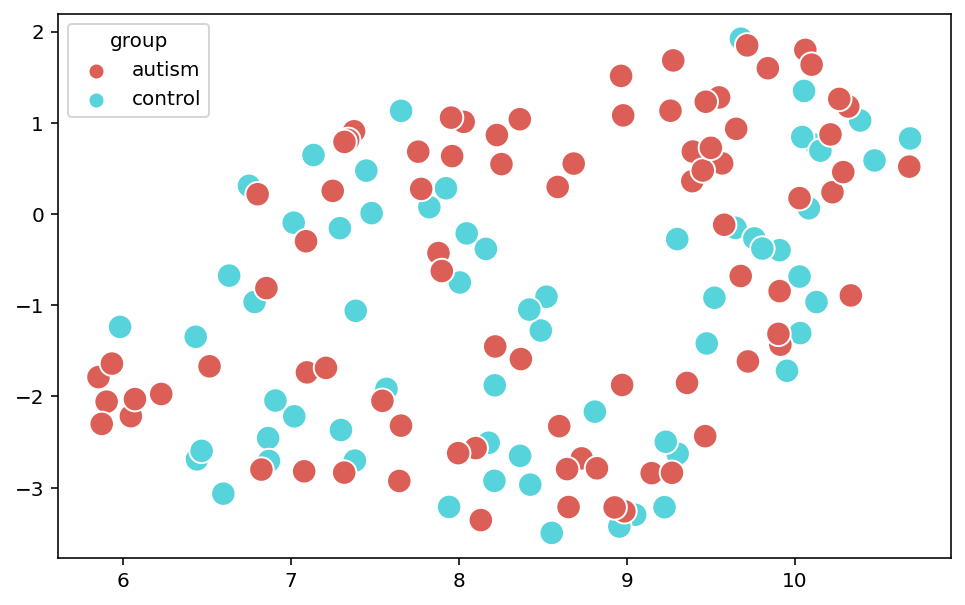

In [12]:
raw_data = gene.iloc[:,1:].values
draw_umap(raw_data)

## Preprocess Data with Between-Group Mean Difference

In [57]:
median = gene.groupby(by=['group']).median()
median

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,90610_at,91580_at,91617_at,91682_at,91684_g_at,91703_at,91816_f_at,91826_at,91920_at,91952_at
group,,,,,,,,,,,,,,,,,,,,,
autism,141.841928,139.635943,1031.983589,150.735616,7.875875,848.464188,37.782935,19.002005,1756.376814,11.470204,...,2062.783528,6.466256,146.038257,47.936812,150.295510,737.164255,18.161098,42.920768,93.178178,261.897964
control,136.778769,143.207814,1174.405681,140.174063,7.807232,862.640590,35.202202,18.898798,1768.706655,11.776884,...,2099.820622,6.320571,153.046486,42.787136,151.933283,783.260151,21.217363,42.474993,88.976787,273.794963


In [61]:
expression = gene.groupby(by=['group']).mean()
x1 = expression.iloc[0,].values
x2 = expression.iloc[1,].values
expression.loc['mean ratio'] = (x1/x2)
expression.loc['autism median'] = median.iloc[0]
expression.loc['control median'] = median.iloc[1]
expression.loc['median ratio'] = (median.iloc[0] / median.iloc[1])
expression

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,90610_at,91580_at,91617_at,91682_at,91684_g_at,91703_at,91816_f_at,91826_at,91920_at,91952_at
group,,,,,,,,,,,,,,,,,,,,,
autism,145.239406,139.101613,1150.717162,151.235071,7.983926,895.311271,38.520847,19.156823,1949.657397,11.534674,...,2054.159106,6.493249,159.354107,49.164529,153.982469,787.973735,19.203685,44.151465,95.529049,275.244657
control,137.585009,142.981458,1267.093233,141.971725,7.859441,878.641795,35.986692,19.126680,1944.452538,11.595492,...,2114.018252,6.447156,157.760102,43.994307,155.820650,849.529392,21.220376,43.427111,90.635512,286.303158
mean ratio,1.055634,0.972865,0.908155,1.065248,1.015839,1.018972,1.070419,1.001576,1.002677,0.994755,...,0.971685,1.007149,1.010104,1.117520,0.988203,0.927541,0.904964,1.016680,1.053991,0.961375
autism median,141.841928,139.635943,1031.983589,150.735616,7.875875,848.464188,37.782935,19.002005,1756.376814,11.470204,...,2062.783528,6.466256,146.038257,47.936812,150.295510,737.164255,18.161098,42.920768,93.178178,261.897964
control median,136.778769,143.207814,1174.405681,140.174063,7.807232,862.640590,35.202202,18.898798,1768.706655,11.776884,...,2099.820622,6.320571,153.046486,42.787136,151.933283,783.260151,21.217363,42.474993,88.976787,273.794963
median ratio,1.037017,0.975058,0.878728,1.075346,1.008792,0.983566,1.073312,1.005461,0.993029,0.973959,...,0.982362,1.023049,0.954208,1.120356,0.989220,0.941149,0.855955,1.010495,1.047219,0.956548


In [ ]:
variance_df = pd.DataFrame(gene.iloc[:,1:].apply(np.var,axis=0),
                          columns=['variance']).sort_values(by='variance', ascending=False)
high_var = variance_df[:(int(len(variance_df)*0.15))].index.tolist()

In [184]:
def filter_by_MeanOrMedian(r = 0.9): # ratio of group means
    #by mean
    by_mean = expression.drop(columns=high_var)
    exp_df = pd.DataFrame((by_mean.iloc[2] > r**(-1))|(by_mean.iloc[2] < r))
    ind_mean = exp_df[exp_df['mean ratio']==True].index.to_list()
    # high variance by median
    by_median = expression.loc[:,high_var]
    exp_df = pd.DataFrame((by_median.iloc[5] > r**(-1))|(by_median.iloc[5] < r))
    ind_median = exp_df[exp_df['median ratio']==True].index.to_list()
    ind = [gene.columns[0]] + ind_mean + ind_median
    
    gene_flt_mean = gene.loc[:,ind]
    return gene_flt_mean


def plot_filter(figsize, r=0.9):
    m_ratio = x1/x2
    median_ratio = expression.iloc[5].values
    
    plt.figure(figsize=figsize)    
    plt.plot(m_ratio, label='mean', alpha=0.6)
    plt.plot(median_ratio, label='median',alpha=0.7)
    
    plt.axhline(y=r, color='r', linestyle='--')
    plt.axhline(y=r**(-1), color='r',linestyle='--')
    plt.legend()
    plt.show()

In [185]:
gene_flt = filter_by_MeanOrMedian(r=0.9)
gene_flt.shape
# gene_flt.to_csv("Data/gene_MeanFiltered_622.csv")

(146, 2708)

In [186]:
gene_flt.head()

,group,1552309_a_at,1552343_s_at,1552344_s_at,1552410_at,1552485_at,1552486_s_at,1552516_a_at,1552546_a_at,1552552_s_at,...,235577_at,222371_at,207838_x_at,202129_s_at,227057_at,209636_at,209082_s_at,218247_s_at,229776_at,203604_at
1,control,99.470374,115.037786,57.910859,73.556402,38.562081,58.042389,53.837294,47.476083,40.021574,...,134.097544,40.444987,230.536760,260.608982,176.356996,229.306430,155.238437,125.595503,155.947974,246.608548
2,control,48.022713,58.748658,57.810835,48.986116,45.479295,43.954288,52.975596,44.962957,45.371391,...,149.602554,48.196484,163.974424,235.590573,126.920650,163.347096,137.662710,144.985016,243.420186,316.609997
3,control,66.203290,177.411780,49.046524,63.104326,37.293570,73.195497,37.928594,62.468674,60.279979,...,105.325503,71.688560,198.397908,244.014827,129.352489,147.203585,221.146561,142.686200,212.493809,249.310010
4,control,40.003741,41.350217,28.071670,46.870263,41.944537,79.626128,48.316565,70.204130,71.720170,...,68.626316,37.419594,218.575820,168.308590,134.555262,344.153411,97.978819,59.573136,204.674704,283.581184
5,control,364.209312,42.952643,32.879285,79.638437,36.281369,28.960869,20.778102,26.954122,100.827894,...,101.597564,38.388652,60.174486,93.524601,27.107854,127.509595,149.089413,175.526494,148.360168,105.231878


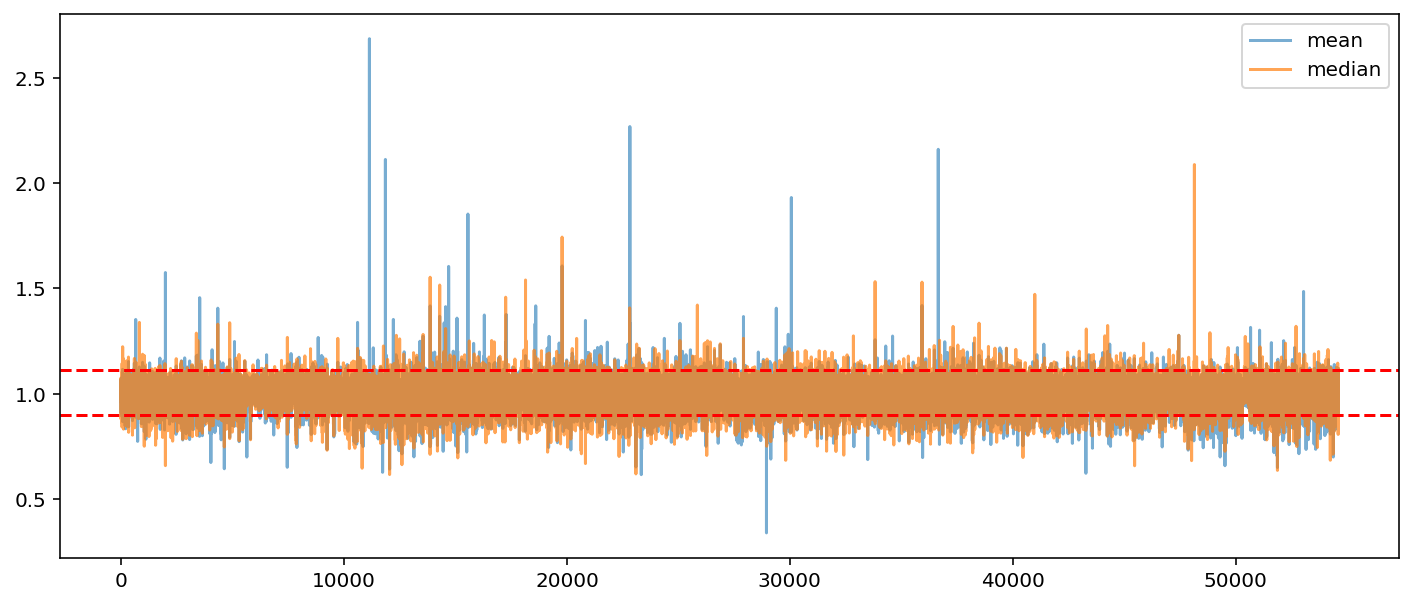

In [187]:
plot_filter(figsize=(12,5))

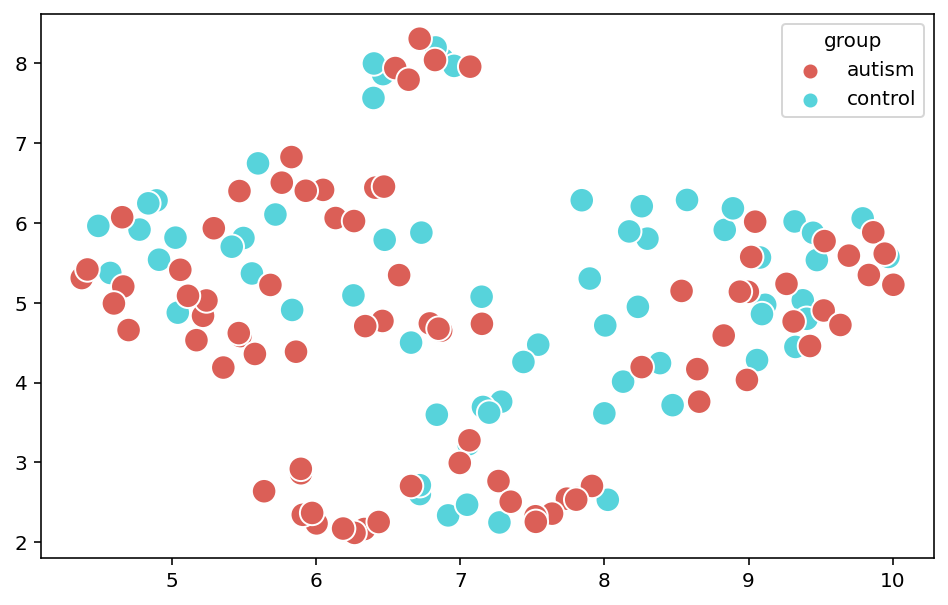

In [188]:
flt_data = gene_flt.iloc[:,1:]
draw_umap(flt_data)

In [303]:
# gene_flt.to_csv('Data/gene_preprocessed_2707.csv')

In [96]:
### Filter by Variance
# plt.figure(figsize=(15,5))
# plt.plot(variance_df[:100])
# plt.xticks(np.arange(100), labels=[f'{i}' for i in range(1,101)],
#           rotation=60)
# plt.show()

In [ ]:
# var_table = variance_df['variance'].describe()
# threshold = var_table[1] + 2*var_table[2]

# ind = variance_df[variance_df['variance'] > threshold].index
# ind = list(gene.columns[1:4]) + list(ind)

# gene_flt_var = gene.loc[:, ind]
# flt_data = gene_flt_var.iloc[:,1:]
# draw_umap(flt_data)

In [140]:
import warnings
warnings.filterwarnings("ignore")

## Selection by Correlation of Feature

__Feature discriminability__: $$S(f) = \frac{\sum^K{P^2_{k}(C_k - c)^2}} {\sigma^2(f)\sum^K{P_{k}(1- P_{k})}}$$ 
- $P(k)$ is the probability of the appearance of the $k^{th}$ class in the dataset
- K is the number of classes; $K=2$
- $\sigma^2(f)$ is the variance of the feature $=Var(f)$

In [176]:
expression.loc['mean expression'] = expression.iloc[:2,:].mean(axis=0)
expression

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,90610_at,91580_at,91617_at,91682_at,91684_g_at,91703_at,91816_f_at,91826_at,91920_at,91952_at
group,,,,,,,,,,,,,,,,,,,,,
autism,145.239406,139.101613,1150.717162,151.235071,7.983926,895.311271,38.520847,19.156823,1949.657397,11.534674,...,2054.159106,6.493249,159.354107,49.164529,153.982469,787.973735,19.203685,44.151465,95.529049,275.244657
control,137.585009,142.981458,1267.093233,141.971725,7.859441,878.641795,35.986692,19.126680,1944.452538,11.595492,...,2114.018252,6.447156,157.760102,43.994307,155.820650,849.529392,21.220376,43.427111,90.635512,286.303158
mean ratio,1.055634,0.972865,0.908155,1.065248,1.015839,1.018972,1.070419,1.001576,1.002677,0.994755,...,0.971685,1.007149,1.010104,1.117520,0.988203,0.927541,0.904964,1.016680,1.053991,0.961375
autism median,141.841928,139.635943,1031.983589,150.735616,7.875875,848.464188,37.782935,19.002005,1756.376814,11.470204,...,2062.783528,6.466256,146.038257,47.936812,150.295510,737.164255,18.161098,42.920768,93.178178,261.897964
control median,136.778769,143.207814,1174.405681,140.174063,7.807232,862.640590,35.202202,18.898798,1768.706655,11.776884,...,2099.820622,6.320571,153.046486,42.787136,151.933283,783.260151,21.217363,42.474993,88.976787,273.794963
median ratio,1.037017,0.975058,0.878728,1.075346,1.008792,0.983566,1.073312,1.005461,0.993029,0.973959,...,0.982362,1.023049,0.954208,1.120356,0.989220,0.941149,0.855955,1.010495,1.047219,0.956548
mean expression,141.412208,141.041536,1208.905197,146.603398,7.921684,886.976533,37.253770,19.141752,1947.054967,11.565083,...,2084.088679,6.470202,158.557105,46.579418,154.901559,818.751563,20.212030,43.789288,93.082281,280.773908


In [183]:
from sklearn.model_selection import KFold

In [284]:
def feature_discimination(Pk, # probability of the appearance of the  𝑘𝑡ℎ class
                        ck, # mean expression by class
                        c,  # mean expression of both classes
                        var,# feature variance
                        k=2): # number of classes (=2)
    upper = sum( [Pk[i]**2 * (ck[i]-c)**2 for i in range(k)] )
    lower = sum( [Pk[i] * (1-Pk[i]) for i in range(k)] )
    D = upper / (var[0]*lower)
    return D

def calc_COR(data=gene_flt.iloc[:,1:]):
    Pk = [gene['group'].value_counts()[0] / len(gene),
          gene['group'].value_counts()[1] / len(gene)]
    
    Sf = []
    # loop through all gene features
    for f in data.columns: 
        var = variance_df.loc[f].tolist()
        ck = expression[f][:2].tolist()
        c = expression[f][6] # mean expression
        # calculate discrimination score for each feature
        Sf.append(feature_discimination(Pk=Pk, ck=ck, c=c, var=var)) 
    return Sf

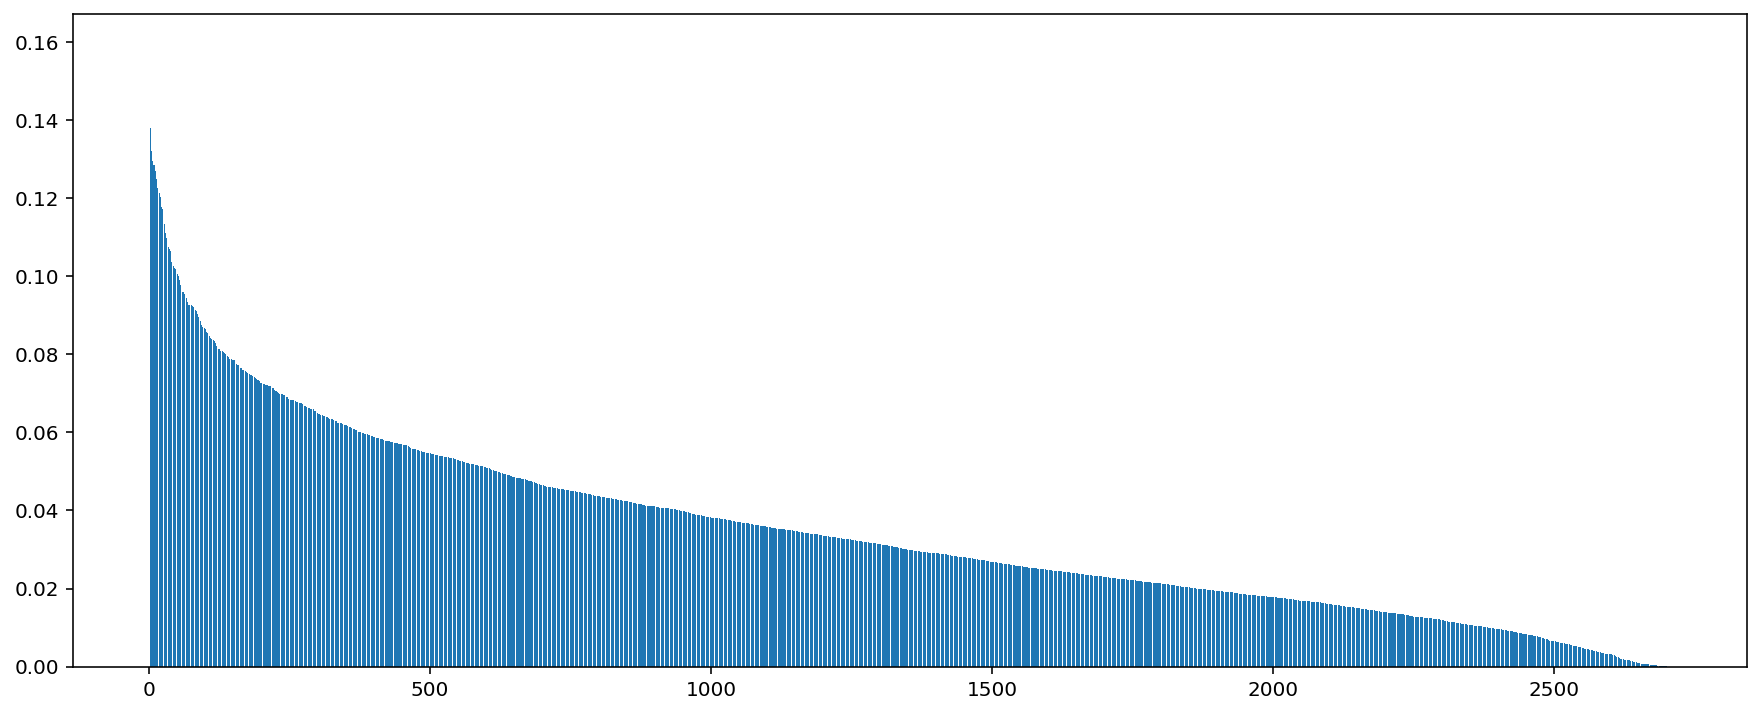

In [287]:
Sf = calc_COR()
cor_df = pd.DataFrame({'cor':Sf},
                      index=gene_flt.columns[1:]).sort_values(by='cor', 
                                                    ascending=False)

# f, ax = plt.subplots(1,2)
plt.figure(figsize=(15,6))
plt.bar(np.arange(2707)+1, cor_df['cor'])
plt.show()

In [272]:
# X = gene_flt.iloc[:,1:]
# # all 2707 features
# fs = gene_flt.columns[1:].tolist()
# f_rank = pd.DataFrame(index=fs)
# i=1

# kf = KFold(n_splits=5, shuffle=True, random_state=40)
# for train, test in kf.split(X):
#     f_rank['rank%d'%i] = calc_COR_rank(X.iloc[train])
#     i+=1

In [294]:
# #selected by coeff from RF model
# RF_f = feature_imp['feature'][:100]
# # selected by coeff from logistic reg
# Logit_f = logit_imp['feature'][:100]

# selected by feature discriminability)
COR_f = cor_df.index.tolist()[:200]

In [301]:
df_filtered = gene_flt.loc[:, COR_f]
df_filtered['group'] = gene['group']
# df_filtered.to_csv('Data/gene_filtered_200.csv')

## Classification

## Logistic Regression 

In [ ]:
# Dataset
X = gene_flt.iloc[:,1:]
y = gene['group']

# logistic regression with L1 penalty
Cs = np.logspace(-5,5,20)
mdl = lm.LogisticRegressionCV(Cs=Cs,
                           cv=5, 
                           penalty='l1',
                           solver='saga', random_state=42).fit(X, y)

plt.semilogx(1/Cs, mdl.scores_['control'].mean(axis=0) )
plt.errorbar(1/Cs, mdl.scores_['control'].mean(axis=0),
             mdl.scores_['control'].std(axis=0)/np.sqrt(10) )
plt.xlabel('lambda (regularization strength)')
plt.ylabel('Score (Classification accuracy)')

In [ ]:
C = Cs[np.argmax(mdl.scores_['control'].mean(axis=0))]
clf = lm.LogisticRegression(C=C, 
                            penalty='l1',
                            solver='saga',
                            random_state=42).fit(X, y)

# rank feature importance by coef from logistic model
importances = np.abs(clf.coef_[0])
feature_names = np.array(X.columns)
logit_imp = pd.DataFrame({'feature':feature_names,'imp':importances})
logit_imp.imp.describe()

logit_imp = logit_imp.sort_values(by='imp', ascending=False)
plt.figure(figsize=(10,4))
plt.plot(np.arange(gene_flt.shape[1]-1), logit_imp['imp'])
plt.xlabel('features')
plt.ylabel('Coefficient')
plt.xticks(rotation=45)
plt.show()

## Random Forest

In [ ]:
X = gene_flt_mean.iloc[:,4:]
y = gene['group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
# Using 622-feature dataset
X = gene_flt_mean.iloc[:,4:]
y = gene['group'].values
# Fit 
feature_names = [f"{i}" for i in X.columns]
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# importances = clf.feature_importances_
# std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

# feature_imp = pd.DataFrame({'feature':feature_names,'imp':importances})
# feature_imp = feature_imp.sort_values(by='imp', ascending=False)

# flted_features = list(feature_imp[feature_imp['imp']!=0]['feature'])
# feature_imp.head()
plt.figure(figsize=(8,4))
plt.bar(np.arange(622)+1,feature_imp['imp'])
# plt.errorbar('feature','imp', data=feature_imp[:20],yerr = std[:20])
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [ ]:
score_train, score_test = [],[]

def my_SVM_CV(n_splits=5): # for k-fold cross-validation):
    X = data.values
    y = gene['group'].values
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold=0
    clf_report_train = clf_report_test = []

    
    for train, test in kf.split(X):
        # obtain classifier
        clf = SVC(random_state=42).fit( X[train,:], y[train] )
        # train report
        train_pred = clf.predict(X[train,:])
#         clf_report_train.append(classification_report(train_pred, y[train]))
        # test report
        test_pred = clf.predict(X[test,:])
#         clf_report_test.append(classification_report(test_pred, y[test]))
        score_train.append( accuracy_score(train_pred, y[train]) )
        score_test.append( accuracy_score(test_pred, y[test]) )
    
        fold+=1
        
    return score_train, score_test


In [ ]:
n_splits = 5
# clf_report_train, clf_report_test = my_SVM_CV(n_splits)
score_train, score_test = my_SVM_CV(n_splits)

In [ ]:
score_train, score_test

In [189]:
from sklearn.metrics import roc_curve, auc, plot_roc_curve